#  Task 2 -Recommend Relevant Keywords with Page Rank Algorithm 
### MICROSOFT ACADEMIC GRAPH PROJECT

#### This notebook walks you through the analysis done for keywords match and script used to visualize our output pertaining to predicting keywords. 

In [8]:
# -*- coding: utf-8 -*-
"""
Created on Tue April  23 19:17:59 2016

@author: Santhosh
"""

from __future__ import division
import operator, re

input_file = '/Users/Santhosh/PaperCollection5.json'

# list that stores all papers
papers = []

# dict to store keyword and associated pid as {{kw1:[pid1, pid2...]}, {kw2:..}...}
keyword_dict = {}

# dict to store {{author1: [pid1, pid2...]}, {a2}...)
author_dict_pid = {}

# dict to store pids and associated keywords {{pid1:[kw1, kw2...]}, {pid2:..}...}
pidKw_dict = {}

# dict to store pids and associated authors {{pid1:[auth1, auth2...]}, {pid2:..}...}
paperAuth_dict = {}   
  
# dict to store pids and associated published years ({pid1:yr, {pid2:yr}...}
paper_pubYr = {}

# dict for actual reference paper ids
actual_refPids = {}



######################## Code Section that reads and stores data using regex #################### 

f_obj = open(input_file)

for line in f_obj:
    try:
        kw = re.findall('"KW":"([^"]*)', line)
        authIds = re.findall('"AuthIds":"([^"]*)',line)
        kw = kw[0].split("|")
        authIds = authIds[0].split("|")
        pap_id = re.findall('"PId":"([^"]*)', line)[0] 
        papers.append(pap_id)        #add(pap_id)
        for i in kw:
            if i in keyword_dict:
                keyword_dict[i].append(pap_id)
            else:
                keyword_dict[i] = [pap_id]
    
        for i in authIds:
            if i in author_dict_pid:
                author_dict_pid[i].append(pap_id)
            else:
                author_dict_pid[i] = [pap_id]

        paperAuth_dict[pap_id] = authIds;
        pub_yr = re.findall('"PublYear":([^,]*)', line)[0]
        paper_pubYr[pap_id] = pub_yr;
        
        refPid = re.findall('"PRefIds":"([^"]*)', line)
        refPid = refPid[0].split("|")
        for i in refPid:
            if pap_id in actual_refPids:
                actual_refPids[pap_id].append(i)
            else:
                actual_refPids[pap_id] = [i]
        actual_refPids[pap_id].remove('')
        
        for i in kw:
            if pap_id in pidKw_dict:
                pidKw_dict[pap_id].append(i)
            else:
                pidKw_dict[pap_id] = [i]
        pidKw_dict[pap_id].remove('')
        

    except Exception, e:
        pass

print "Total no. of papers found in our subset:                " + str(len(papers)) +"  papers"
print "Total no. of unique keywords in our subset              " + str(len(keyword_dict)) +"  keywords"
print "Total no. of unique authors present in our subset       " + str(len(author_dict_pid)) +"  authors"


#################### End Regex section  ################################################

RecomendedPids = []
searchPid = raw_input("Please enter the paperID to compute page rank: ")
print 


relKeyWords = pidKw_dict[searchPid]
print "List of related topics found for papers with pid:                "  

for rkw in relKeyWords:
    print(rkw)
    if rkw:
        RecomendedPids.extend(keyword_dict[rkw])
    
print "Total no. of related papers(with above)found prior to applying our Page Rank:   " +str(len(RecomendedPids)) + '\n' '\n'

print "We have to filter out papers that appeared after a paper was published" + '\n'
ourPprYr = paper_pubYr[searchPid]
for p in RecomendedPids:
    if paper_pubYr[p] > ourPprYr:
        RecomendedPids.remove(p)

print "Done with filtering out papers published after the year:   " + str(ourPprYr)
print "So now the total number of recommended papers in hand is:  " +str(len(RecomendedPids))
print " ------------------- Filtered Out Papers -------------------- [1]" + '\n'

RecomendedAuthors = []
for recPid in RecomendedPids:
    RecomendedAuthors.extend(paperAuth_dict[recPid])

print "Total number of related authors found from related papers: " +str(len(RecomendedAuthors))

authID_count = {}

for a in RecomendedAuthors:
            if a in authID_count:
                authID_count[a].append(len(author_dict_pid[a]))
            else:
                authID_count[a] = [len(author_dict_pid[a])]


if '' in authID_count:
    del authID_count['']
   
keyMax = []

# top authors dict with their weight 
topAuth = {}

def cal_weight(max_papers_count, max_weight, curr_paper):
    """
    Function to compute the weight for the papers based on author popularity. 
    """
    return max_weight*curr_paper/max_papers_count


"""
Computing overall Max_Weight of authors
"""
try:
    authID_count.pop('0.0')
except:
    pass

tempMax = max(authID_count, key=lambda k: authID_count[k])
print "The author who wrote max papers in this recomended list is :" + str(tempMax)
print "and he wrote                                " + str(len(author_dict_pid[tempMax])) + " papers" + '\n' '\n'
allmax_AuthAppear = len(author_dict_pid[tempMax])




for items in xrange(10):
    tempKey = max(authID_count.iterkeys(), key=(lambda key: authID_count[key]))
    keyMax.append(tempKey)
    topAuth[tempKey] = cal_weight(allmax_AuthAppear, 0.2, len(author_dict_pid[tempKey]))
    del authID_count[tempKey]
    cal_weight
    

print "List of 20 authors with maximum number of papers under them in this field with their assigned weights are:" +'\n'
sorted_topAuth = sorted(topAuth.items(), key=operator.itemgetter(1) , reverse = True)
print sorted_topAuth
print
print "Next step is to assign these weights to the paperIds which are written by the above authors!" + '\n'
weight_dict = {"kw":0.6, "ap":0.2, "pRank":0.2}



Paper_toAuthWeight = {}
# After the author weight is computed, we assign it to the Paper_toAuthWeight dict
for aids in topAuth.keys():
    for pap in author_dict_pid[aids]:
        Paper_toAuthWeight[pap]= topAuth[aids]

#Paper_toAuthWeight = sorted(Paper_toAuthWeight.items(), key=operator.itemgetter(1) , reverse = True)
print 'The number of paper weights are assigned from the author weights are:   ' + str(len(Paper_toAuthWeight.keys()))
print " ----------- Author popularity assigned for Papers ------------ [2]" + '\n'





recPapers_toKw = {}
referenceKw = pidKw_dict[searchPid]


def compute_paperWt(referenceKw, RecomendedPids, recPapers_toKw, maxPaperWt):
    for k in RecomendedPids:
        noMatch = 0
        for i in pidKw_dict[k]:
            for j in referenceKw:
                if i==j:
                    noMatch +=1
                    
        tempWt = maxPaperWt*noMatch/len(pidKw_dict[k])

        recPapers_toKw[k] = tempWt
        
    
compute_paperWt(referenceKw, RecomendedPids, recPapers_toKw, 0.6)


tempPw = recPapers_toKw.copy()
maxMatchPapers = []
for items in xrange(200):
    tempKey = max(tempPw.iterkeys(), key=(lambda key: tempPw[key]))
    
    maxMatchPapers.append(tempKey)
    #Paper_toAuthWeight[tempKey] = cal_weight(allmax_AuthAppear, 0.4, len(author_dict_pid[tempKey]))
    del tempPw[tempKey]
    
print " ----------- Paper Similarity assigned for Keywords ------------ [3]" + '\n'
print "Recomended Keywords are:"
    

kwList = ['key']

for i in maxMatchPapers:
    kwList.extend(pidKw_dict[i])

print 
print kwList

Total no. of papers found in our subset:                117003  papers
Total no. of unique keywords in our subset              17124  keywords
Total no. of unique authors present in our subset       224343  authors
Please enter the paperID to compute page rank: 5D03E53B

List of related topics found for papers with pid:                
data mining
matrix decomposition
noise
nonnegative matrix factorization
multi document summarization
k means
non negative matrix factorization
feature extraction
text analysis
coherence
Total no. of related papers(with above)found prior to applying our Page Rank:   5973


We have to filter out papers that appeared after a paper was published

Done with filtering out papers published after the year:   2008
So now the total number of recommended papers in hand is:  3738
 ------------------- Filtered Out Papers -------------------- [1]

Total number of related authors found from related papers: 15654
The author who wrote max papers in this recomended list i

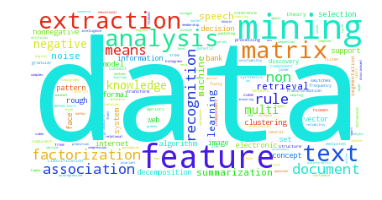

In [9]:
from os import path
from wordcloud import WordCloud
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
%matplotlib inline


text=json.dumps(kwList)

wc = WordCloud(background_color="white", max_words=200)
# generate word cloud
wc.generate(text)

plt.imshow(wc)
plt.axis("off")
plt.figure()
plt.show()

Explanations for the above plot is mentioned in the report. 